## Graph Neural Networks

We now use Tensorflow to classify nodes in a graph using Graph Convolution Networks.

First, install gcn on your machine using the 'python setup.py install' command.

# Exercise for semisupervised classification on citation networks

In [1]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.models import Model,MLP
from gcn.layers import *

In [2]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
#flags.DEFINE_float('learning_rate', 0.1, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
#flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
#flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 100, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [4]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

#--------------- Your code here --------------#

def masked_mean_square_error(preds,labels,mask):
    """L2 loss with masking."""
    loss = tf.nn.l2_loss(preds - labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)


#--------------------------------------------#

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [5]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [6]:
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)


In [7]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

In [8]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95399 train_acc= 0.07143 val_loss= 1.95070 val_acc= 0.20600 time= 0.05262
Epoch: 0002 train_loss= 1.94801 train_acc= 0.29286 val_loss= 1.94716 val_acc= 0.37000 time= 0.01589
Epoch: 0003 train_loss= 1.94218 train_acc= 0.48571 val_loss= 1.94333 val_acc= 0.47000 time= 0.01544
Epoch: 0004 train_loss= 1.93654 train_acc= 0.56429 val_loss= 1.93922 val_acc= 0.50400 time= 0.01512
Epoch: 0005 train_loss= 1.92665 train_acc= 0.66429 val_loss= 1.93517 val_acc= 0.50400 time= 0.01609
Epoch: 0006 train_loss= 1.92017 train_acc= 0.70000 val_loss= 1.93110 val_acc= 0.51400 time= 0.01588
Epoch: 0007 train_loss= 1.91050 train_acc= 0.71429 val_loss= 1.92704 val_acc= 0.52000 time= 0.01615
Epoch: 0008 train_loss= 1.89941 train_acc= 0.71429 val_loss= 1.92310 val_acc= 0.51600 time= 0.01684
Epoch: 0009 train_loss= 1.89015 train_acc= 0.75714 val_loss= 1.91920 val_acc= 0.52000 time= 0.01577
Epoch: 0010 train_loss= 1.88369 train_acc= 0.67143 val_loss= 1.91527 val_acc= 0.52000 time= 0.01595


Epoch: 0087 train_loss= 0.97249 train_acc= 0.92857 val_loss= 1.35100 val_acc= 0.78000 time= 0.01714
Epoch: 0088 train_loss= 0.94913 train_acc= 0.93571 val_loss= 1.34459 val_acc= 0.78000 time= 0.01690
Epoch: 0089 train_loss= 0.97455 train_acc= 0.91429 val_loss= 1.33826 val_acc= 0.78000 time= 0.01739
Epoch: 0090 train_loss= 0.97957 train_acc= 0.91429 val_loss= 1.33204 val_acc= 0.78000 time= 0.02074
Epoch: 0091 train_loss= 0.92480 train_acc= 0.95000 val_loss= 1.32596 val_acc= 0.78000 time= 0.01981
Epoch: 0092 train_loss= 0.95817 train_acc= 0.92143 val_loss= 1.32011 val_acc= 0.78000 time= 0.01683
Epoch: 0093 train_loss= 0.89500 train_acc= 0.95000 val_loss= 1.31456 val_acc= 0.77800 time= 0.01560
Epoch: 0094 train_loss= 0.86474 train_acc= 0.92857 val_loss= 1.30937 val_acc= 0.77800 time= 0.01595
Epoch: 0095 train_loss= 0.90715 train_acc= 0.96429 val_loss= 1.30445 val_acc= 0.78000 time= 0.01451
Epoch: 0096 train_loss= 0.89772 train_acc= 0.93571 val_loss= 1.29963 val_acc= 0.78000 time= 0.01512


Epoch: 0178 train_loss= 0.60540 train_acc= 0.98571 val_loss= 1.08044 val_acc= 0.77800 time= 0.01733
Epoch: 0179 train_loss= 0.63127 train_acc= 0.95000 val_loss= 1.07856 val_acc= 0.78200 time= 0.01960
Epoch: 0180 train_loss= 0.69479 train_acc= 0.93571 val_loss= 1.07661 val_acc= 0.78200 time= 0.01729
Epoch: 0181 train_loss= 0.62900 train_acc= 0.97857 val_loss= 1.07482 val_acc= 0.78600 time= 0.01605
Epoch: 0182 train_loss= 0.64596 train_acc= 0.92857 val_loss= 1.07334 val_acc= 0.78600 time= 0.01488
Epoch: 0183 train_loss= 0.59649 train_acc= 0.97857 val_loss= 1.07162 val_acc= 0.78400 time= 0.01442
Epoch: 0184 train_loss= 0.64177 train_acc= 0.96429 val_loss= 1.07015 val_acc= 0.78400 time= 0.01505
Epoch: 0185 train_loss= 0.61356 train_acc= 0.96429 val_loss= 1.06902 val_acc= 0.78400 time= 0.01597
Epoch: 0186 train_loss= 0.64748 train_acc= 0.95000 val_loss= 1.06780 val_acc= 0.78600 time= 0.01516
Epoch: 0187 train_loss= 0.63458 train_acc= 0.96429 val_loss= 1.06619 val_acc= 0.78800 time= 0.01585


In [9]:
# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

Test set results: cost= 1.01263 accuracy= 0.81400 time= 0.00826


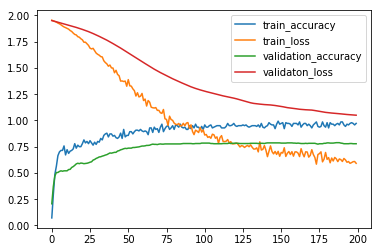

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.show()

# 1. With no weight decay / dropout  (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **without weight decay and without dropout**.

In [11]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += tf.nn.l2_loss(var) # no decay

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=False,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=False,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [12]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    # feed_dict.update({placeholders['dropout']: FLAGS.dropout}) no dropout

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95414 train_acc= 0.13571 val_loss= 1.94961 val_acc= 0.33000 time= 0.06426
Epoch: 0002 train_loss= 1.94643 train_acc= 0.57143 val_loss= 1.94491 val_acc= 0.40800 time= 0.02976
Epoch: 0003 train_loss= 1.93817 train_acc= 0.67857 val_loss= 1.94026 val_acc= 0.41800 time= 0.02423
Epoch: 0004 train_loss= 1.92958 train_acc= 0.68571 val_loss= 1.93589 val_acc= 0.43400 time= 0.02606
Epoch: 0005 train_loss= 1.92087 train_acc= 0.69286 val_loss= 1.93165 val_acc= 0.44600 time= 0.02323
Epoch: 0006 train_loss= 1.91195 train_acc= 0.71429 val_loss= 1.92752 val_acc= 0.46400 time= 0.02099
Epoch: 0007 train_loss= 1.90281 train_acc= 0.73571 val_loss= 1.92348 val_acc= 0.49000 time= 0.02012
Epoch: 0008 train_loss= 1.89349 train_acc= 0.75714 val_loss= 1.91946 val_acc= 0.50000 time= 0.02062
Epoch: 0009 train_loss= 1.88393 train_acc= 0.77143 val_loss= 1.91541 val_acc= 0.53000 time= 0.01946
Epoch: 0010 train_loss= 1.87410 train_acc= 0.77143 val_loss= 1.91131 val_acc= 0.53400 time= 0.01933


Epoch: 0086 train_loss= 0.86001 train_acc= 0.98571 val_loss= 1.38855 val_acc= 0.79000 time= 0.02014
Epoch: 0087 train_loss= 0.85202 train_acc= 0.98571 val_loss= 1.38269 val_acc= 0.79200 time= 0.02299
Epoch: 0088 train_loss= 0.84420 train_acc= 0.98571 val_loss= 1.37688 val_acc= 0.79000 time= 0.01825
Epoch: 0089 train_loss= 0.83654 train_acc= 0.98571 val_loss= 1.37127 val_acc= 0.79000 time= 0.01948
Epoch: 0090 train_loss= 0.82906 train_acc= 0.98571 val_loss= 1.36556 val_acc= 0.79000 time= 0.01761
Epoch: 0091 train_loss= 0.82173 train_acc= 0.98571 val_loss= 1.35981 val_acc= 0.79000 time= 0.01880
Epoch: 0092 train_loss= 0.81456 train_acc= 0.98571 val_loss= 1.35422 val_acc= 0.79200 time= 0.01760
Epoch: 0093 train_loss= 0.80753 train_acc= 0.98571 val_loss= 1.34880 val_acc= 0.78800 time= 0.01751
Epoch: 0094 train_loss= 0.80066 train_acc= 0.98571 val_loss= 1.34343 val_acc= 0.78800 time= 0.01804
Epoch: 0095 train_loss= 0.79393 train_acc= 0.98571 val_loss= 1.33808 val_acc= 0.78800 time= 0.01722


Epoch: 0176 train_loss= 0.50704 train_acc= 1.00000 val_loss= 1.08919 val_acc= 0.78800 time= 0.01854
Epoch: 0177 train_loss= 0.50513 train_acc= 1.00000 val_loss= 1.08740 val_acc= 0.78800 time= 0.02120
Epoch: 0178 train_loss= 0.50323 train_acc= 1.00000 val_loss= 1.08576 val_acc= 0.79000 time= 0.02018
Epoch: 0179 train_loss= 0.50136 train_acc= 1.00000 val_loss= 1.08417 val_acc= 0.79000 time= 0.01769
Epoch: 0180 train_loss= 0.49951 train_acc= 1.00000 val_loss= 1.08247 val_acc= 0.79000 time= 0.01836
Epoch: 0181 train_loss= 0.49766 train_acc= 1.00000 val_loss= 1.08092 val_acc= 0.79000 time= 0.01771
Epoch: 0182 train_loss= 0.49586 train_acc= 1.00000 val_loss= 1.07936 val_acc= 0.79000 time= 0.01864
Epoch: 0183 train_loss= 0.49406 train_acc= 1.00000 val_loss= 1.07767 val_acc= 0.78800 time= 0.01771
Epoch: 0184 train_loss= 0.49227 train_acc= 1.00000 val_loss= 1.07587 val_acc= 0.78800 time= 0.01804
Epoch: 0185 train_loss= 0.49052 train_acc= 1.00000 val_loss= 1.07432 val_acc= 0.78800 time= 0.01881


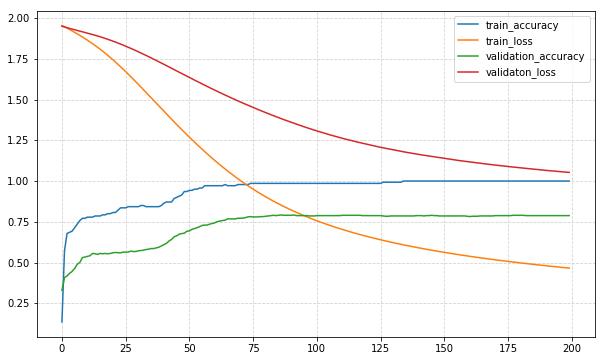

In [13]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 2. Change it to $A^2$ (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **after changing the adjacency matrix to $A^2$ **.

In [14]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)
    
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_square = normalize_adj(np.power(adj, 2).tocoo())
    
    return sparse_to_tuple(adj_square)



In [15]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95374 train_acc= 0.12143 val_loss= 1.95021 val_acc= 0.21600 time= 0.02896
Epoch: 0002 train_loss= 1.94714 train_acc= 0.30000 val_loss= 1.94647 val_acc= 0.27800 time= 0.02752
Epoch: 0003 train_loss= 1.93967 train_acc= 0.41429 val_loss= 1.94247 val_acc= 0.30800 time= 0.02240
Epoch: 0004 train_loss= 1.93359 train_acc= 0.47143 val_loss= 1.93844 val_acc= 0.31600 time= 0.02481
Epoch: 0005 train_loss= 1.92555 train_acc= 0.43571 val_loss= 1.93449 val_acc= 0.32600 time= 0.01919
Epoch: 0006 train_loss= 1.91714 train_acc= 0.57143 val_loss= 1.93064 val_acc= 0.32400 time= 0.02099
Epoch: 0007 train_loss= 1.91050 train_acc= 0.54286 val_loss= 1.92687 val_acc= 0.32800 time= 0.01834
Epoch: 0008 train_loss= 1.90186 train_acc= 0.51429 val_loss= 1.92333 val_acc= 0.33000 time= 0.01795
Epoch: 0009 train_loss= 1.89511 train_acc= 0.55000 val_loss= 1.91981 val_acc= 0.33200 time= 0.01918
Epoch: 0010 train_loss= 1.88445 train_acc= 0.55000 val_loss= 1.91620 val_acc= 0.33800 time= 0.01812


Epoch: 0086 train_loss= 0.98548 train_acc= 0.95000 val_loss= 1.41350 val_acc= 0.78600 time= 0.01704
Epoch: 0087 train_loss= 1.04115 train_acc= 0.92143 val_loss= 1.40818 val_acc= 0.78400 time= 0.01808
Epoch: 0088 train_loss= 1.03225 train_acc= 0.92143 val_loss= 1.40302 val_acc= 0.78200 time= 0.01946
Epoch: 0089 train_loss= 1.04500 train_acc= 0.91429 val_loss= 1.39761 val_acc= 0.78400 time= 0.01539
Epoch: 0090 train_loss= 1.02071 train_acc= 0.90714 val_loss= 1.39227 val_acc= 0.78200 time= 0.01475
Epoch: 0091 train_loss= 0.98314 train_acc= 0.92143 val_loss= 1.38735 val_acc= 0.77800 time= 0.01588
Epoch: 0092 train_loss= 0.98308 train_acc= 0.92143 val_loss= 1.38241 val_acc= 0.77400 time= 0.01498
Epoch: 0093 train_loss= 0.95656 train_acc= 0.90714 val_loss= 1.37738 val_acc= 0.77600 time= 0.01609
Epoch: 0094 train_loss= 0.99934 train_acc= 0.90000 val_loss= 1.37182 val_acc= 0.77600 time= 0.01805
Epoch: 0095 train_loss= 0.92877 train_acc= 0.94286 val_loss= 1.36574 val_acc= 0.77600 time= 0.01550


Epoch: 0169 train_loss= 0.66290 train_acc= 0.97857 val_loss= 1.12643 val_acc= 0.78600 time= 0.01647
Epoch: 0170 train_loss= 0.69648 train_acc= 0.97143 val_loss= 1.12404 val_acc= 0.78800 time= 0.01781
Epoch: 0171 train_loss= 0.68106 train_acc= 0.93571 val_loss= 1.12126 val_acc= 0.78800 time= 0.01746
Epoch: 0172 train_loss= 0.64777 train_acc= 0.97857 val_loss= 1.11853 val_acc= 0.78800 time= 0.01573
Epoch: 0173 train_loss= 0.70112 train_acc= 0.94286 val_loss= 1.11591 val_acc= 0.78600 time= 0.01505
Epoch: 0174 train_loss= 0.71591 train_acc= 0.95000 val_loss= 1.11346 val_acc= 0.78400 time= 0.01571
Epoch: 0175 train_loss= 0.75268 train_acc= 0.92143 val_loss= 1.11163 val_acc= 0.78400 time= 0.01570
Epoch: 0176 train_loss= 0.66825 train_acc= 0.95000 val_loss= 1.11010 val_acc= 0.78400 time= 0.01495
Epoch: 0177 train_loss= 0.65017 train_acc= 0.98571 val_loss= 1.10814 val_acc= 0.78400 time= 0.01513
Epoch: 0178 train_loss= 0.65874 train_acc= 0.95000 val_loss= 1.10642 val_acc= 0.78400 time= 0.01586


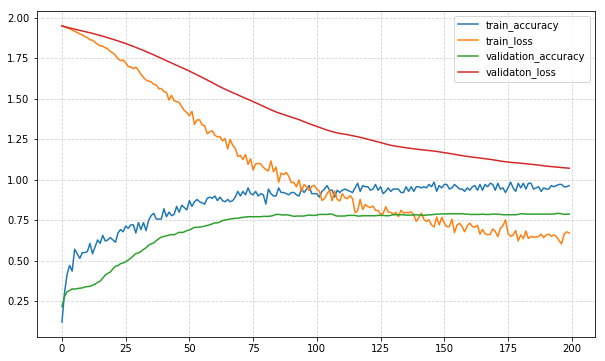

In [16]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 3. Change to the $L_2$ loss

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **with the loss function being $L_2$ loss**.

In [20]:
#--------------- Your code here --------------#
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
                                              self.placeholders['labels_mask'])
#        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
#                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)

#--------------------------------------------#

In [21]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 1.95314 train_acc= 0.17143 val_loss= 1.94934 val_acc= 0.35800 time= 0.02355
Epoch: 0002 train_loss= 1.94701 train_acc= 0.43571 val_loss= 1.94535 val_acc= 0.42000 time= 0.02205
Epoch: 0003 train_loss= 1.93991 train_acc= 0.55000 val_loss= 1.94098 val_acc= 0.50000 time= 0.02836
Epoch: 0004 train_loss= 1.93230 train_acc= 0.61429 val_loss= 1.93619 val_acc= 0.59000 time= 0.02234
Epoch: 0005 train_loss= 1.92234 train_acc= 0.74286 val_loss= 1.93139 val_acc= 0.63800 time= 0.01634
Epoch: 0006 train_loss= 1.91620 train_acc= 0.75000 val_loss= 1.92684 val_acc= 0.66400 time= 0.01529
Epoch: 0007 train_loss= 1.90641 train_acc= 0.79286 val_loss= 1.92259 val_acc= 0.66800 time= 0.01486
Epoch: 0008 train_loss= 1.90064 train_acc= 0.77857 val_loss= 1.91856 val_acc= 0.67400 time= 0.01497
Epoch: 0009 train_loss= 1.89145 train_acc= 0.80714 val_loss= 1.91453 val_acc= 0.67200 time= 0.01589
Epoch: 0010 train_loss= 1.88057 train_acc= 0.80000 val_loss= 1.91033 val_acc= 0.68000 time= 0.01470


Epoch: 0088 train_loss= 0.95197 train_acc= 0.94286 val_loss= 1.38260 val_acc= 0.80200 time= 0.01690
Epoch: 0089 train_loss= 0.99181 train_acc= 0.93571 val_loss= 1.37756 val_acc= 0.80000 time= 0.01939
Epoch: 0090 train_loss= 0.96357 train_acc= 0.94286 val_loss= 1.37299 val_acc= 0.80200 time= 0.01858
Epoch: 0091 train_loss= 0.93801 train_acc= 0.93571 val_loss= 1.36858 val_acc= 0.79800 time= 0.01475
Epoch: 0092 train_loss= 0.94842 train_acc= 0.91429 val_loss= 1.36416 val_acc= 0.79800 time= 0.01520
Epoch: 0093 train_loss= 0.94799 train_acc= 0.93571 val_loss= 1.35984 val_acc= 0.79800 time= 0.01531
Epoch: 0094 train_loss= 0.95595 train_acc= 0.90000 val_loss= 1.35540 val_acc= 0.79800 time= 0.01473
Epoch: 0095 train_loss= 0.94299 train_acc= 0.93571 val_loss= 1.35056 val_acc= 0.79800 time= 0.01556
Epoch: 0096 train_loss= 0.94064 train_acc= 0.92857 val_loss= 1.34548 val_acc= 0.79800 time= 0.01560
Epoch: 0097 train_loss= 0.90469 train_acc= 0.94286 val_loss= 1.34019 val_acc= 0.79800 time= 0.01508


Epoch: 0171 train_loss= 0.68751 train_acc= 0.95714 val_loss= 1.11182 val_acc= 0.79200 time= 0.01635
Epoch: 0172 train_loss= 0.64617 train_acc= 0.94286 val_loss= 1.11004 val_acc= 0.79200 time= 0.01752
Epoch: 0173 train_loss= 0.66016 train_acc= 0.95000 val_loss= 1.10763 val_acc= 0.79200 time= 0.01665
Epoch: 0174 train_loss= 0.62758 train_acc= 0.95000 val_loss= 1.10494 val_acc= 0.79200 time= 0.01654
Epoch: 0175 train_loss= 0.63393 train_acc= 0.96429 val_loss= 1.10263 val_acc= 0.79200 time= 0.01491
Epoch: 0176 train_loss= 0.66327 train_acc= 0.97857 val_loss= 1.10071 val_acc= 0.79400 time= 0.01487
Epoch: 0177 train_loss= 0.61990 train_acc= 0.96429 val_loss= 1.09859 val_acc= 0.79200 time= 0.01499
Epoch: 0178 train_loss= 0.65620 train_acc= 0.93571 val_loss= 1.09621 val_acc= 0.79200 time= 0.01503
Epoch: 0179 train_loss= 0.65587 train_acc= 0.95714 val_loss= 1.09428 val_acc= 0.79200 time= 0.01508
Epoch: 0180 train_loss= 0.70108 train_acc= 0.93571 val_loss= 1.09381 val_acc= 0.79200 time= 0.01537


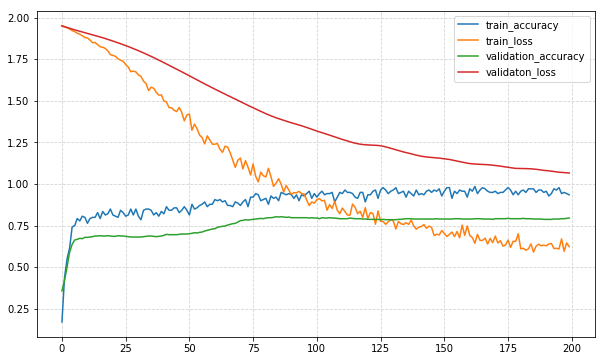

In [22]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

# 4. Change the input graph/label

Now, create the input graphs using a Stochastic Block Model. The number of nodes should be 500, and then feed the true labels using $20%$ of the nodes. The degree of a node must be used as the feature.
Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps for this input graph.

In [150]:
#--------------- Your code here --------------#
# Randomly generate graph with 500 nodes
G = nx.fast_gnp_random_graph(500, 0.005, directed = True)
adj_matrix = nx.adjacency_matrix(G)

# Generate feature matrix
feature_matrix = np.zeros([500, 1])
i = 0
for node, degree in G.degree().items():
    feature_matrix[i] = degree
    i += 1

# Feed labels to 20 nodes
y_train = np.zeros([500, 1])
nodes_true_index = np.random.randint(500, size = 20) # index
for i in range(len(G.nodes())):
    if i in nodes_true_index:
        y_train[i] = 1


idx_train = range(20)
idx_val = range(20, 20 + 200)

train_mask = sample_mask(idx_train, len(y_train))
val_mask = sample_mask(idx_val, len(y_train))

y_val = np.zeros(y_train.shape)
for i in range(500):
    if val_mask[i] == True:
        y_val[i] = y_train[i]

# y_train[train_mask, :] = y_train[train_mask, :]
# y_val[val_mask, :] = y_train[val_mask, :]

#--------------------------------------------#

In [152]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
#        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
#                                                 self.placeholders['labels_mask'])
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [154]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

ValueError: Cannot feed value of shape (500, 1) for Tensor 'Placeholder_5:0', which has shape '(?, 7)'

In [144]:
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)